# Lib imports

In [1]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder
import seaborn as sns


/Users/arsknz/miniforge3/envs/main_nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Models imports

In [2]:
# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score

# kaggle username and api key to env params and dataset download

In [3]:
"""
with open("/Users/arsknz/Downloads/kaggle.json") as f:
    us_key = json.load(f)

os.environ["KAGGLE_USERNAME"] = us_key["username"]
os.environ["KAGGLE_KEY"] = us_key["key"]
"""
"""
!kaggle datasets download -d gabrielrichter/sales-by-products-assortment  -p ~/osnov/code/sbor_data/ --force
!unzip sales-by-products-assortment.zip
"""

'\n!kaggle datasets download -d gabrielrichter/sales-by-products-assortment  -p ~/osnov/code/sbor_data/ --force\n!unzip sales-by-products-assortment.zip\n'

# Dataset to Dataframe and some analize

In [4]:
df = pd.read_csv("sales_assortments.csv")
df.head()

,Index,Date,Sales,Assortment
0,0,2014 aug 01,34201.792962,drink
1,1,2014 aug 02,8404.176909,drink
2,2,2014 aug 03,62851.436278,drink
3,3,2014 aug 04,79310.692652,drink
4,4,2014 aug 05,83689.581215,drink


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       1700 non-null   int64  
 1   Date        1700 non-null   object 
 2   Sales       1700 non-null   float64
 3   Assortment  1700 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 53.2+ KB


In [6]:
df.describe()

,Index,Sales
count,1700.000000,1700.000000
mean,849.500000,62781.191201
std,490.892045,92768.741518
min,0.000000,102.352682
25%,424.750000,5187.490255
50%,849.500000,19941.191462
75%,1274.250000,81454.998270
max,1699.000000,522164.520062


# Prepair to train models

In [7]:
def part_of_year(data):
    data = data.split()
    return data[1]

In [8]:
df["Season"] = df["Date"].apply(part_of_year)
df.drop(columns=["Date", "Index"], inplace=True)
df

,Sales,Assortment,Season
0,34201.792962,drink,aug
1,8404.176909,drink,aug
2,62851.436278,drink,aug
3,79310.692652,drink,aug
4,83689.581215,drink,aug
...,...,...,...
1695,302.356902,drink,sep
1696,24966.162859,drink,sep
1697,12161.923139,drink,sep
1698,25187.078681,drink,sep


In [9]:
X_cat = df[["Assortment", "Season"]]
y = df["Sales"].squeeze()

te = TargetEncoder(cols=["Assortment", "Season"])
X_cat_encoded = te.fit_transform(X_cat, y)
X_cat_encoded

,Assortment,Season
0,95243.827928,118747.351216
1,95243.827928,118747.351216
2,95243.827928,118747.351216
3,95243.827928,118747.351216
4,95243.827928,118747.351216
...,...,...
1695,95243.827928,81195.252952
1696,95243.827928,81195.252952
1697,95243.827928,81195.252952
1698,95243.827928,81195.252952


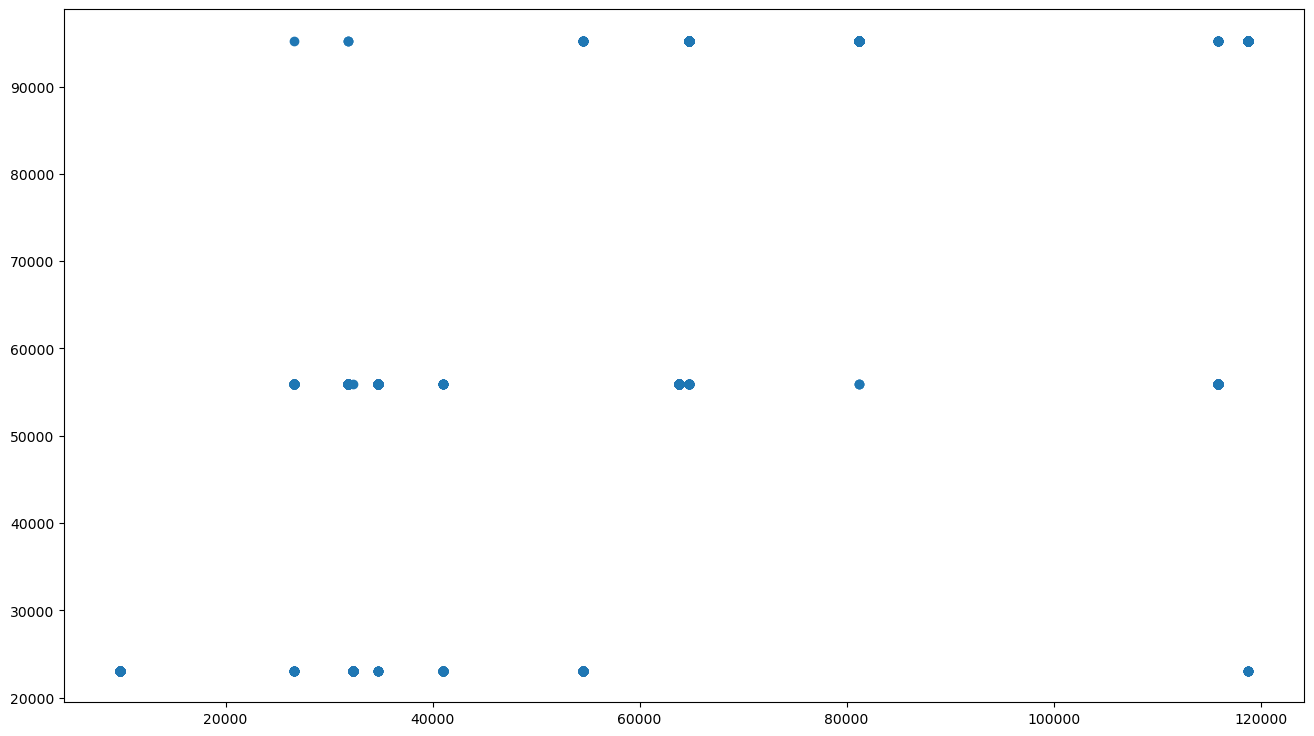

In [10]:
plt.figure(figsize=(16, 9))
plt.scatter(X_cat_encoded["Season"], X_cat_encoded["Assortment"])
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cat_encoded, y, test_size=0.2)

# Train models w GridSearchCV

In [ ]:
results = {}


def train_model(name, model, param_grid):
    """Обучение модели с GridSearchCV и сохранение результатов"""
    search = GridSearchCV(model, param_grid, cv=3, scoring="r2", n_jobs=-1)
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    results[name] = {
        "best_params": search.best_params_,
        "r2": r2_score(y_test, y_pred),
        "rmse": mean_squared_error(y_test, y_pred) ** 0.5,
        "y_pred": y_pred,
    }


models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "AdaBoost": AdaBoostRegressor(),
    "RandomForest": RandomForestRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
}


param_grids = {
    "Linear": {},
    "Ridge": {"alpha": [0.01, 0.1, 1, 10]},
    "Lasso": {"alpha": [0.01, 0.1, 1, 10]},
    "ElasticNet": {"alpha": [0.01, 0.1, 1, 10], "l1_ratio": [0.0, 0.5, 1.0]},
    "AdaBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1]},
    "RandomForest": {"n_estimators": [100, 200], "max_depth": [3, 5, 10, None]},
    "DecisionTree": {
        "max_depth": [3, 5, 10, None],
        "criterion": ["squared_error", "friedman_mse"],
    },
}


In [14]:
for name, model in models.items():
    print(f"Training {name}...")
    train_model(name, model, param_grids[name])

Training Linear...
Training Ridge...
Training Lasso...
Training ElasticNet...
Training AdaBoost...


/Users/arsknz/miniforge3/envs/main_nn/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.364e+12, tolerance: 7.866e+08
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/arsknz/miniforge3/envs/main_nn/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+12, tolerance: 7.896e+08
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers im

Training RandomForest...
Training DecisionTree...


# R2 metric result

In [15]:
for key in results.keys():
    print(f"{key}: {results[key]['r2']}")

Linear: 0.14996527744033772
Ridge: 0.14996527744027877
Lasso: 0.14996527745257338
ElasticNet: 0.14996527745257338
AdaBoost: 0.24012232725322336
RandomForest: 0.25545307354172986
DecisionTree: 0.25537344865139966
